In [1]:
import pprint as pp
pp.PrettyPrinter(indent=4)
from typing import Tuple, Union, List
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle
import tensorflow as tf
from tensorflow.keras.utils import load_img

from src.utils.funcs import init_COCO, process_img_annotations, rotate
from src.utils.classes import CategoricalDataGen, bbox_worker
from src.models.models import IoU, YOLOLoss
from src.models.loss import BoundingBox_Processor



2022-12-31 10:23:37.788728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 10:23:37.993751: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%aimport src.utils.funcs
%aimport src.utils.classes
%aimport src.models

In [4]:
np.set_printoptions(formatter={'float_kind':"{:.4f}".format})

In [ ]:
img = np.asarray(load_img("./data/images/val/screws_015.png", target_size=(384, 512)), dtype=np.float32)

In [ ]:
h_img = np.vsplit(img, 8)

In [ ]:
g_img = [np.hsplit(x, 8) for x in h_img]

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(16, 12))
for i, ax_r in zip(g_img, axs):
    for j, ax in zip(i, ax_r):
        ax.imshow(j / 255)
        ax.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
inputs = tf.random.uniform([384, 512, 3], 0, 1)

In [ ]:
inputs = np.asarray(load_img("./data/images/val/screws_015.png", target_size=(1440, 1920)), dtype=np.float32)

In [ ]:
tensor = tf.Variable(inputs/255, dtype=tf.float32)
s_tensor = tf.split(tensor, num_or_size_splits=8, axis=1)
print(s_tensor[0].shape)
stack = tf.stack(s_tensor)
print(stack.shape)
grid_tensor = tf.split(tf.stack(s_tensor), num_or_size_splits=8, axis=1)
print(grid_tensor[0].shape)

In [ ]:
plt.imshow(grid_tensor[0][3])

In [9]:
3/13 # Correct IoU

0.23076923076923078

In [10]:
y_true = [1, 1, 5, 3]
y_pred = [0, 0, 4, 2]

iou = IoU(y_pred, y_true)
print(iou)

True Area: 8
Predicted Area: 8
x_max: 1, x_min: 4
y_max: 1, y_min: 2
Intersection: 3
Union: 13
0.23076923076923078


In [ ]:
w = 1920
h = 1440

a = 856
b= 1201

x_grid = 8
y_grid = 6

x_cell = int(divmod(a, w/x_grid)[0])
y_cell = int(divmod(b, h/y_grid)[0])
print(x_cell, y_cell)

In [ ]:
def find_grid_loc(extent:Tuple[int, int]=(1440, 1920),
                  grid_shape:Tuple[int, int]=(6, 8),
                  point:Tuple[float, float]=(0., 0.)):
    x_pos = int(divmod(point[1], extent[1]/grid_shape[1])[0])
    y_pos = int(divmod(point[0], extent[0]/grid_shape[0])[0])

    return x_pos, y_pos

In [ ]:
labels = np.zeros((7,7, 13 + 6), dtype=np.float32)
labels[0, 3, 13:] = 1, 2, 3, 4, 5, 6
labels[0, 3]



In [5]:
data = init_COCO("./data/", ["train", "val", "test"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [6]:
test = CategoricalDataGen('test', data, "./data/images", target_size=(384, 512))

In [7]:
xdivs = 12
ydivs = 9

In [8]:
labels = test.get_labels(divs=(ydivs, xdivs), num_classes=13, num_boxes=3,
                input_size=(1440, 1920))
labels.shape

(60, 12, 9, 19)

ValueError: cannot reshape array of size 123120 into shape (108,19)

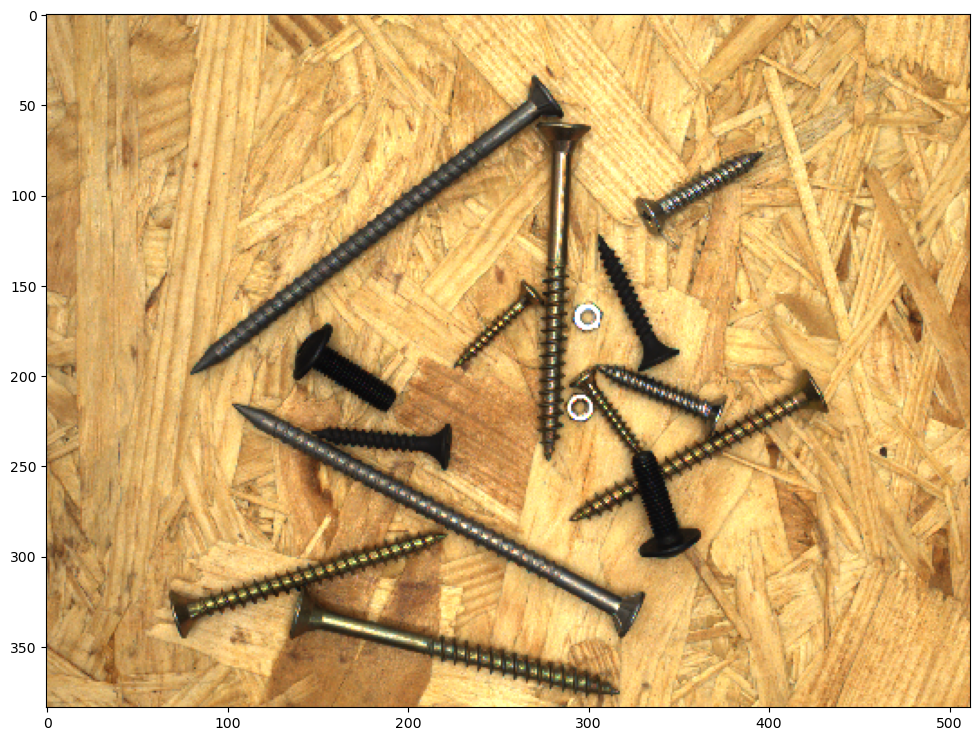

In [10]:
img = np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512)), dtype=np.float32)
img = img / 255
fig, ax = plt.subplots(figsize=(xdivs, ydivs))
ax.imshow(img)
y_true = label_corners[0]
print(y_true.shape)
y_true = tf.reshape(y_true, [ydivs * xdivs, 4, 2])
for label in y_true:
    # print(f"Label:\n{label}")
    bbox = label
    ax.add_patch(Polygon(bbox, fill=None, edgecolor='tab:purple', lw=2))
    ax.add_patch(Circle(np.mean(bbox, axis=0), radius=3, fill=None, edgecolor="red", lw=2))
    ax.scatter(bbox[2][0], bbox[2][1], marker='x', color='springgreen', s=60)
    ax.scatter(bbox[0][0], bbox[0][1], marker='x', color='tomato', s=60)
# y_pred = preds[0]
# y_pred = y_pred.reshape(ydivs * xdivs, 31)
# for label in y_pred:
#     bbox_raw = label[14:19]
#     bbox, _, _ = process_img_annotations(bbox_raw)
#     anchor = bbox[2][1], bbox[2][0]
#     ax.add_patch(Polygon(bbox, fill=None, edgecolor='tomato', lw=2))
#     ax.add_patch(Circle(np.mean(bbox, axis=0), radius=3, fill=None, edgecolor="tab:blue", lw=2))
#     ax.scatter(bbox[2][0], bbox[2][1], marker='x', color='tab:blue', s=60)
#     ax.scatter(bbox[0][0], bbox[0][1], marker='x', color='tab:blue', s=60)
ax.axis('off')
plt.show()

In [9]:
preds = np.zeros((60, xdivs, ydivs, 13 + 3 * 6), dtype=np.float32)
preds[...,:19] = preds[...,:19] + labels
preds[..., 19:25] = labels[..., 13:19] 
preds[..., 25:] = labels[..., 13:19] 
b_e = preds[..., 13]
b_e = b_e.reshape((preds.shape[:-1] + (1,)))
print(b_e.shape)
box_exists = np.concatenate((b_e, b_e, b_e, b_e, b_e), axis=-1)
known_loss = np.asarray([10, 10, 5, 20, np.pi * .05])
known_loss = np.full(preds.shape[:-1] + (5,), known_loss, dtype=np.float32)
preds[..., 14:19] = known_loss + preds[..., 14:19]
preds[..., 20:25] = box_exists * (preds[..., 20:25] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))
preds[..., 26:] = box_exists * (preds[..., 26:] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))



(60, 12, 9, 1)


In [12]:
loss = YOLOLoss(.5, grid_divs=(9, 12), num_boxes=3, num_classes=13)

In [13]:
print(f"y_true: {labels.shape}\ny_preds: {preds.shape}")
loss(labels, preds)

y_true: (60, 12, 9, 19)
y_preds: (60, 12, 9, 31)


2022-12-29 14:54:57.327356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 14:54:57.339930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 14:54:57.339955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 14:54:57.342714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 14:54:57.342745: I tensorflow/com

<tf.Tensor: shape=(), dtype=float32, numpy=1.981692>

In [14]:
box1 = np.array([[6, 8], [6, 2], [4, 2], [4, 8]], dtype=np.float32)
center = np.mean(box1, axis=0)
angle = np.pi / 4
box2 = [rotate(point, angle, center) for point in box1]
print(f"{box1}\n{box2}")

[[2.0000 4.0000]
 [2.0000 -4.0000]
 [-2.0000 -4.0000]
 [-2.0000 4.0000]]
[array([-1.4142, 4.2426], dtype=float32), array([4.2426, -1.4142], dtype=float32), array([1.4142, -4.2426], dtype=float32), array([-4.2426, 1.4142], dtype=float32)]


In [10]:
def get_Gbbox(worker):
    box1 = worker.label_box.copy()
    box2 = worker.pred_box.copy()
    box = []
    box.extend(box1)
    box.extend(box2)

    x, y = [[x for x, y in box],
            [y for x, y in box]]

    maxX = np.max(x)
    minX = np.min(x)
    maxY = np.max(y)
    minY = np.min(y)

    c_box = np.asarray([[maxX, maxY],
                        [maxX, minY],
                        [minX, minY],
                        [minX, maxY]], dtype=np.float32)

    return c_box

def GIoU(worker):
    box1 = worker.label_box.copy()
    box2 = worker.pred_box.copy()
    box = []
    box.extend(box1)
    box.extend(box2)

    x, y = [[x for x, y in box],
            [y for x, y in box]]

    maxX = np.max(x)
    minX = np.min(x)
    maxY = np.max(y)
    minY = np.min(y)

    c_box = np.asarray([[maxX, maxY],
                        [maxX, minY],
                        [minX, minY],
                        [minX, maxY]], dtype=np.float32)
    C = np.ones((3, 3), dtype=np.float32)
    C[:,:2] = C[:,:2] * c_box[:-1]
    C = np.abs(np.linalg.det(C))
    union = worker.union()

    return worker.IoU() - np.abs(C / union) / C 
GIoU(boxes)

NameError: name 'boxes' is not defined

In [16]:
label_1 = [4, 6, 1.5, 4, np.deg2rad(-13)]
pred = [3.2, 5.63, 1.2, 3.6, np.deg2rad(-25)]
boxes = bbox_worker(label_1, pred) 

In [ ]:
if boxes.intersection:
    intersection_points = boxes.intersection.copy()
    center = np.mean(intersection_points, axis=0)
    intersection_points = np.append(intersection_points, center.reshape(1, 2), axis=0)
    i_x, i_y = [[x for x, y in intersection_points],
                [y for x, y in intersection_points]] 
# print(boxes.intersection)
print(f"Intersection Area = {boxes.intersection_area()}")
print(f"IoU = {boxes.IoU()}")
print(f"GIoU = {GIoU(boxes)}")

fig, ax = plt.subplots(figsize=(8,8))
ax.set(
        xlim=[-10, 10],
        ylim=[-10, 10],
        xticks=range(-10, 10, 1),
        yticks=range(-10, 10, 1)
        )
ax.grid(visible=True, zorder=0)
ax.add_patch(Polygon(boxes.label_box, fill=None, edgecolor='springgreen', lw=1, zorder=10))
ax.add_patch(Polygon(boxes.pred_box, fill=None, edgecolor='tomato', lw=1, zorder=10))
if boxes.intersection:
    ax.add_patch(Polygon(boxes.intersection, edgecolor='tab:purple', zorder=10, alpha=.4))
ax.add_patch(Polygon(get_Gbbox(boxes), fill=None, edgecolor='black', lw=1.5, zorder=10, alpha=.6))

# ax.scatter(i_x, i_y, marker='x', s=30, color='tab:purple')
ax.axhline(0, -10, 10, lw=.5, color='black', linestyle='--')
ax.axvline(0, -10, 10, lw=.5, color='black', linestyle='--')
plt.show()



In [ ]:
print(type(labels), type(preds))

In [11]:
box_cutter = BoundingBox_Processor()

In [12]:
label_corners = box_cutter.get_corners(labels)
pred_corners = box_cutter.get_corners(preds)
pred_corners = pred_corners[0]
label_corners = label_corners[0]



2022-12-31 10:24:45.659953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-31 10:24:45.671719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-31 10:24:45.671740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-31 10:24:45.675519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-31 10:24:45.675540: I tensorflow/com

In [13]:
def get_edges(tensor):
    z = tf.roll(tensor, shift=-1, axis=-2)
    t = tf.stack([tensor, z], axis=-2)
    return t
    
true_edges = get_edges(label_corners)
pred_edges = get_edges(pred_corners)
print(pred_edges.shape)

(60, 12, 9, 4, 2, 2)


In [14]:
def get_intersections(edge1, edge2):
    edge_a = edge1[..., 0:1, :, :]
    edge_b = edge2[..., 0:, :, :]
    print(f"edge_a shape: {edge_a.shape}")
    print(f"edge_b shape: {edge_b.shape}")
    print(edge_a[0,5, 4, 0:])
    print(edge_b[0,5, 4, 0:])
    x1 = edge_a[..., 0:1, 0:1]
    y1 = edge_a[..., 0:1, 1:]
    x2 = edge_a[..., 1:, 0:1]
    y2 = edge_a[..., 1:, 1:]
    print(f"x1 shape: {x1.shape}")
    print(f"y1 shape: {y1.shape}")
    # print(f"x1 value: {x1[0,5,4]}")
    # print(f"y1 value: {y1[0,5,4]}")
    # print(f"x2 value: {x2[0,5,4]}")
    # print(f"y2 value: {y2[0,5,4]}")
    x3 = edge_b[..., 0:1, 0:1]
    y3 = edge_b[..., 0:1, 1:]
    x4 = edge_b[..., 1:, 0:1]
    y4 = edge_b[..., 1:, 1:]
    # print(f"x3 value: {x3[0,5,4]}")
    # print(f"y3 value: {y3[0,5,4]}")
    # print(f"x4 value: {x4[0,5,4]}")
    # print(f"y4 value: {y4[0,5,4]}")
    
    denom =  (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
    # print(f"denom shape: {denom.shape}")
    # print(f"denom[0, 5, 4]:\n{denom[0, 5, 4]}")
    ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denom
    ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denom
    # print(f"ua value: {ua[0, 5, 4]}")
    # print(f"ub value: {ub[0, 5, 4]}")
    zeros = tf.fill(tf.shape(ua), 0.0)
    ones = tf.fill(tf.shape(ua), 1.0)
    ua_1 = tf.cast(tf.math.less_equal(ua, ones), dtype=tf.float32)
    ua_2 = tf.cast(tf.math.greater_equal(ua, zeros), dtype=tf.float32)
    ua = tf.clip_by_value(tf.math.add(ua_1, ua_2), 0, 1)
    zeros = tf.fill(tf.shape(ub), 0.0)
    ones = tf.fill(tf.shape(ub), 1.0)
    ub_1 = tf.cast(tf.math.less_equal(ub, ones), dtype=tf.float32)
    ub_2 = tf.cast(tf.math.greater_equal(ub, zeros), dtype=tf.float32)
    ub = tf.clip_by_value(tf.math.add(ub_1, ub_2), 0, 1)
    # print(ua[0, 5, 4])
    xnum = (x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)
    ynum = (x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)
    x_i = (xnum / denom) * ua
    y_i = (ynum / denom) * ub
    print(x_i.shape)
    intersections = tf.stack([x_i, y_i], axis=-3)
    print(intersections.shape)
    print(intersections[0, 5, 4])




get_intersections(true_edges, pred_edges)

edge_a shape: (60, 12, 9, 1, 2, 2)
edge_b shape: (60, 12, 9, 4, 2, 2)
tf.Tensor(
[[[279.6179 159.3425]
  [265.7286 144.4976]]], shape=(1, 2, 2), dtype=float32)
tf.Tensor(
[[[295.0650 158.3904]
  [275.0793 142.8293]]

 [[275.0793 142.8293]
  [223.0832 209.6096]]

 [[223.0832 209.6096]
  [243.0689 225.1707]]

 [[243.0689 225.1707]
  [295.0650 158.3904]]], shape=(4, 2, 2), dtype=float32)
x1 shape: (60, 12, 9, 1, 1, 1)
y1 shape: (60, 12, 9, 1, 1, 1)
(60, 12, 9, 4, 1, 1)
(60, 12, 9, 4, 2, 1, 1)
tf.Tensor(
[[[[234.8893]]

  [[111.5367]]]


 [[[270.1231]]

  [[149.1947]]]


 [[[604.5298]]

  [[506.6093]]]


 [[[287.6442]]

  [[167.9212]]]], shape=(4, 2, 1, 1), dtype=float32)


In [15]:
label_1 = [4, 6, 1.5, 4, np.deg2rad(-13)]
pred = [3.2, 5.63, 1.2, 3.6, np.deg2rad(-25)]
boxes = bbox_worker(label_1, pred) 
boxes.label_box

[array([5.1807, 7.7800]),
 array([4.2809, 3.8825]),
 array([2.8193, 4.2200]),
 array([3.7191, 8.1175])]

In [16]:
# print(boxes.intersection)
test_label = label_corners[0, 5, 4]
print(test_label)
test_pred = pred_corners[0, 5, 4]
print(test_pred)

tf.Tensor(
[[279.6179 159.3425]
 [265.7286 144.4976]
 [218.5303 188.6575]
 [232.4196 203.5024]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[295.0650 158.3904]
 [275.0793 142.8293]
 [223.0832 209.6096]
 [243.0689 225.1707]], shape=(4, 2), dtype=float32)


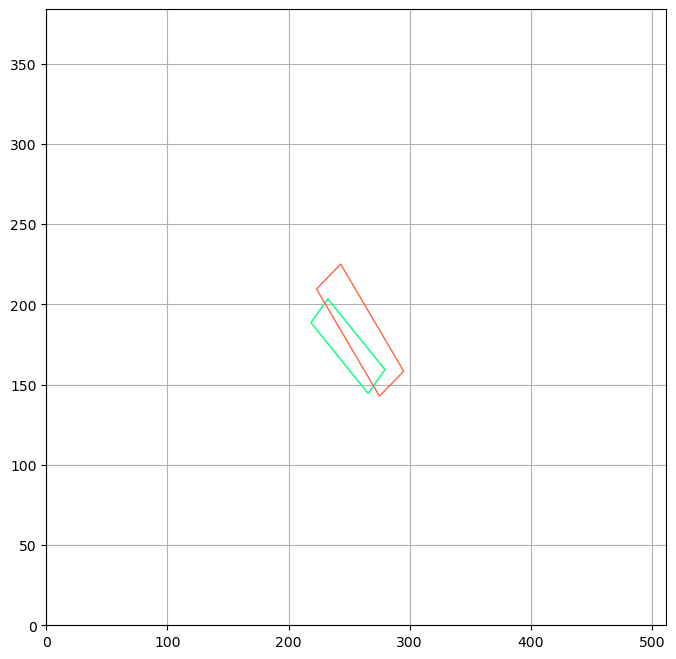

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set(
        xlim=[0, 512],
        ylim=[0, 384],
        )
ax.grid(visible=True, zorder=0)
ax.add_patch(Polygon(test_label.numpy(), fill=None, edgecolor='springgreen', lw=1, zorder=10))
ax.add_patch(Polygon(test_pred.numpy(), fill=None, edgecolor='tomato', lw=1, zorder=10))
# if boxes.intersection:
#     ax.add_patch(Polygon(boxes.intersection, edgecolor='tab:purple', zorder=10, alpha=.4))
# ax.add_patch(Polygon(get_Gbbox(boxes), fill=None, edgecolor='black', lw=1.5, zorder=10, alpha=.6))

# ax.scatter(i_x, i_y, marker='x', s=30, color='tab:purple')
ax.axhline(0, -10, 10, lw=.5, color='black', linestyle='--')
ax.axvline(0, -10, 10, lw=.5, color='black', linestyle='--')
plt.show()

In [18]:
def get_intersections(edge1, edge2):
    edge_a = edge1[..., 2:3, :, :]
    edge_b = edge2[..., 0:, :, :]
    print(f"edge_a shape: {edge_a.shape}")
    print(f"edge_b shape: {edge_b.shape}")
    print(f"edge_a points:\n{tf.squeeze(edge_a[0,5, 4, 0:])}")
    print(f"edge_b points:\n{tf.squeeze(edge_b[0,5, 4, 0:])}")
    x1 = edge_a[..., 0:1, 0:1]
    y1 = edge_a[..., 0:1, 1:]
    x2 = edge_a[..., 1:, 0:1]
    y2 = edge_a[..., 1:, 1:]
    print(f"x1 shape: {x1.shape}")
    print(f"y1 shape: {y1.shape}")
    # print(f"x1 value: {x1[0,5,4]}")
    # print(f"y1 value: {y1[0,5,4]}")
    # print(f"x2 value: {x2[0,5,4]}")
    # print(f"y2 value: {y2[0,5,4]}")
    x3 = edge_b[..., 0:1, 0:1]
    y3 = edge_b[..., 0:1, 1:]
    x4 = edge_b[..., 1:, 0:1]
    y4 = edge_b[..., 1:, 1:]
    # print(f"x3 value: {x3[0,5,4]}")
    # print(f"y3 value: {y3[0,5,4]}")
    # print(f"x4 value: {x4[0,5,4]}")
    # print(f"y4 value: {y4[0,5,4]}")
    
    denom =  (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
    # print(f"denom shape: {denom.shape}")
    print(f"denom:\n{tf.squeeze(denom[0, 5, 4], axis=[-2, -1])}")
    ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denom
    ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denom
    print(f"ua value: {tf.squeeze(ua[0, 5, 4], axis=[-2, -1])}")
    print(f"ub value: {tf.squeeze(ub[0, 5, 4], axis=[-2, -1])}")
    zeros = tf.fill(tf.shape(ua), 0.0)
    ones = tf.fill(tf.shape(ua), 1.0)
    ua_1 = tf.cast(tf.math.less_equal(ua, ones), dtype=tf.float32)
    ua_2 = tf.cast(tf.math.greater_equal(ua, zeros), dtype=tf.float32)
    ua = tf.clip_by_value(tf.math.add(ua_1, ua_2), 0, 1)
    zeros = tf.fill(tf.shape(ub), 0.0)
    ones = tf.fill(tf.shape(ub), 1.0)
    ub_1 = tf.cast(tf.math.less_equal(ub, ones), dtype=tf.float32)
    ub_2 = tf.cast(tf.math.greater_equal(ub, zeros), dtype=tf.float32)
    ub = tf.clip_by_value(tf.math.add(ub_1, ub_2), 0, 1)
    print(tf.squeeze(ua[0, 5, 4], axis=[-2, -1]))
    print(tf.squeeze(ub[0, 5, 4], axis=[-2, -1]))
    xnum = (x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)
    ynum = (x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)
    x_i = (xnum / denom) * ua
    y_i = (ynum / denom) * ub
    print(x_i.shape)
    intersections = tf.squeeze(tf.stack([x_i, y_i], axis=-3), axis=[-2, -1])
    print(intersections.shape)
    print(intersections[0, 5, 4])




get_intersections(true_edges, pred_edges)

edge_a shape: (60, 12, 9, 1, 2, 2)
edge_b shape: (60, 12, 9, 4, 2, 2)
edge_a points:
[[218.5303 188.6575]
 [232.4196 203.5024]]
edge_b points:
[[[295.0650 158.3904]
  [275.0793 142.8293]]

 [[275.0793 142.8293]
  [223.0832 209.6096]]

 [[223.0832 209.6096]
  [243.0689 225.1707]]

 [[243.0689 225.1707]
  [295.0650 158.3904]]]
x1 shape: (60, 12, 9, 1, 1, 1)
y1 shape: (60, 12, 9, 1, 1, 1)
denom:
[80.5526 1699.4060 -80.5528 -1699.4058]
ua value: [-22.2944 0.8200 4.3188 2.0815]
ub value: [19.3232 0.8685 2.7736 0.0841]
tf.Tensor([1.0000 1.0000 1.0000 1.0000], shape=(4,), dtype=float32)
tf.Tensor([1.0000 1.0000 1.0000 1.0000], shape=(4,), dtype=float32)
(60, 12, 9, 4, 1, 1)
(60, 12, 9, 4, 2)
tf.Tensor(
[[-91.1222 -142.3006]
 [229.9193 200.8299]
 [278.5160 252.7703]
 [247.4403 219.5565]], shape=(4, 2), dtype=float32)
